https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

Useful link on deconvolution 
https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

Layer size setup 
https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchsummary

import argparse
import os
import random

from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
root_path = "../data"
train_data = datasets.MNIST(
    root = root_path,
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = root_path, 
    train = False, 
    transform = ToTensor()
)

In [3]:
# Root directory for dataset
"data/MNIST"


# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
# image_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 8

# Size of feature maps in generator
ngf = 16

# Size of feature maps in discriminator
ndf = 16

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [4]:
dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, )

device cuda:0


<Figure size 576x576 with 0 Axes>

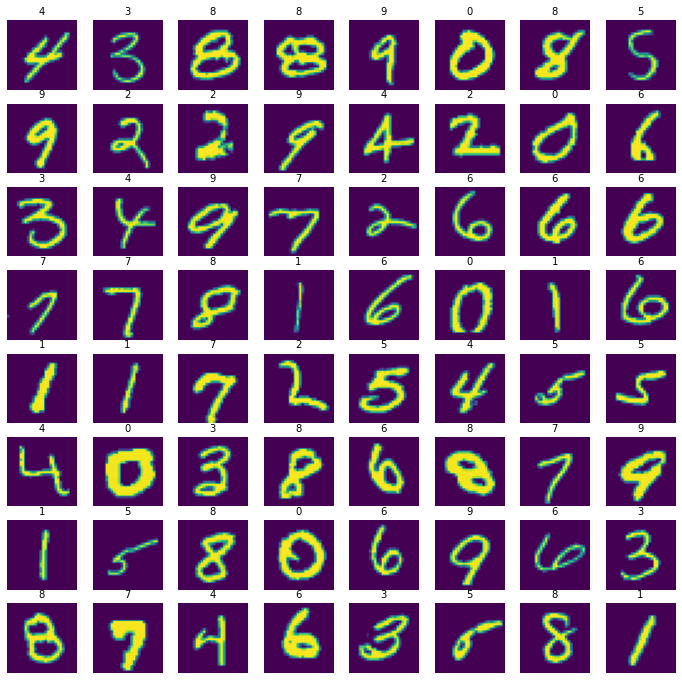

In [6]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("device", device)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))


fig, axarr = plt.subplots(nrows=8, ncols=8, figsize=(12, 12))
faxarr = axarr.flatten()

for i in np.arange(64):

    im = real_batch[0][i]
    label = real_batch[1][i]
    faxarr[i].imshow(im.numpy()[0, :, :])
    faxarr[i].set_title(label.numpy(), fontsize=10)
    faxarr[i].axis("off")

In [17]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [24]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [8]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            # in, out
            # 8, 
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [20]:
# Create the generator
netG = Generator(ngpu).to(device)

In [23]:
summary(netG, (8,))

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv_transpose2d, but got input of size: [2, 8]

In [9]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(8, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [12]:
from torchsummary import summary

In [16]:
summary(netG, (28, 28))

RuntimeError: Given transposed=1, weight of size [8, 128, 4, 4], expected input[1, 2, 28, 28] to have 8 channels, but got 2 channels instead

In [30]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [27]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [28]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [29]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [73]:
torchsummary

NameError: name 'torchsummary' is not defined